1- A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.


2- Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.


3- Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 7?


4- Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?



# Instalndo as bibliotecas necessarias.

In [4]:
pip install statsforecast


In [5]:
pip install hierarchicalforecast


In [6]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


In [7]:
pip install google-cloud-bigquery

In [8]:
pip install pandas-gbq

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from unidecode import unidecode
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.formula.api import ols

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, HoltWinters

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder

from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Carregando os dados do bigquery

In [10]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

project_id = 'desafiolhae'
table_id = 'desafiolhae.dev_wilson.analise_ds'

client = bigquery.Client(project=project_id)

In [13]:
query = client.query(f"select * from {table_id}")

df=query.to_dataframe()

In [14]:
display(df.columns)

Index(['productsalesId', 'productid', 'productcompletename', 'productname',
       'productmakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardcost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystomanufacture', 'ProductLine', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'orderdate',
       'StoreID', 'storename', 'AnnualSales', 'AnnualRevenue', 'BankName',
       'BusinessType', 'YearOpened', 'Specialty', 'SquareFeet', 'Brands',
       'Internet', 'NumberEmployees', 'territoryname',
       'territorycountryregioncode', 'territoryregiongroup',
       'territorysalesytd', 'territorysaleslastyear', 'territorycostytd',
       'territorycostlastyear', 'salespersonid', 'salespersonbonusifquota',
       'salespersonachievequota', 'productstotal', 'completetotal',
       'categories', 'categoriesgroups'],
      dtype='object')

# Análises exploratória

In [159]:
df.isnull().sum()
df['StoreID'] = df['StoreID'].fillna(0)
df['storename'] = df['storename'].fillna("loja Online")
df['salespersonid'] = df['salespersonid'].fillna(0)


Tratando algumas colunas que não serão utilizadas

In [19]:
df1=df[df['productfinishedgoodsflag']!=0]
df1.drop(columns=['productsalesId', 'salespersonid','productfinishedgoodsflag','productstotal','completetotal','salespersonachievequota'])

#criando a coluna "month":
df1['orderdate'] = pd.to_datetime(df1['orderdate'])
df1['month'] = df1['orderdate'].dt.to_period("M")


In [22]:
functions = {
    'productquantity': 'sum',
    'productcompletename': 'first',
    'productname': 'first',
    'productmakeflag': 'first',
    'productsafetystocklevel': 'first',
    'productreorderpoint': 'first',
    'productstandardcost': 'first',
    'productlistprice': 'first',
    'productsize': 'first',
    'productweight': 'first',
    'productdaystomanufacture': 'first',
    'ProductLine': 'first',
    'productclass': 'first',
    'productstyle': 'first',
    'productquantity': 'first',
    'productunitprice': 'first',
    'orderdate': 'first',
    'storename': 'first',
    'AnnualSales': 'first',
    'AnnualRevenue': 'first',
    'BankName': 'first',
    'BusinessType': 'first',
    'YearOpened': 'first',
    'Specialty': 'first',
    'SquareFeet': 'first',
    'Brands': 'first',
    'Internet': 'first',
    'NumberEmployees': 'first',
    'territoryname': 'first',
    'territorycountryregioncode': 'first',
    'territoryregiongroup': 'first',
    'territorysalesytd': 'first',
    'territorysaleslastyear': 'first',
    'territorycostytd': 'first',
    'territorycostlastyear': 'first',
    'categoriesgroups': 'first',
    'categories': 'first'
}
grouped_df1 = df1.groupby(['productid','StoreID','month'], as_index=False).agg(functions).reset_index()

In [23]:
print(f"Quantidade de lojas: {grouped_df1['StoreID'].nunique()}")
print(f"Quantidade de produtos: {grouped_df1['productid'].nunique()}")
quantidade_pares_distintos = len(grouped_df1[['StoreID', 'productid']].drop_duplicates())
print(f"A quantidade de pares distintos StoreID X productid é: {quantidade_pares_distintos}")

Quantidade de lojas: 635
Quantidade de produtos: 250
A quantidade de pares distintos StoreID X productid é: 20511


Analisando quantos produtos foram vendidos mais que 5 vezes na mesma loja

In [33]:
result_df = grouped_df1.groupby(['productid', 'StoreID'])['month'].nunique().reset_index()

result_df.columns = ['productid', 'StoreID', 'distinct_month_count']

print(result_df[result_df['distinct_month_count']>5])

       productid  StoreID  distinct_month_count
5            707      302                     6
7            707      318                     6
9            707      340                     7
10           707      344                     6
16           707      370                     9
...          ...      ...                   ...
11694        860      534                     6
11720        860      794                     6
11752        860     1336                     6
11756        860     1414                     6
11771        860     1962                     6

[1724 rows x 3 columns]


1- A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

Escolhendo um produto para prevê a sazonalidade. neste caso o produto foi o Sport-100 Helmet, Red

In [34]:
functions = {'StoreID': 'first'}
grouped_by_product = grouped_df1.groupby(['productid', 'month'], as_index=False).agg(functions).reset_index()
productid_counts = grouped_by_product['productid'].value_counts()
print(productid_counts)

711    34
707    32
738    32
742    32
743    32
       ..
911     2
927     2
942     2
943     2
897     1
Name: productid, Length: 250, dtype: Int64


In [36]:
functions = {
    'orderdate': 'first',
    'productquantity': 'sum',
    'productcompletename': 'first'
}

grouped_by_product = df1.groupby(['productid', 'month', 'StoreID']).agg(functions).reset_index()


In [53]:
print(df1.columns)


Index(['productsalesId', 'productid', 'productcompletename', 'productname',
       'productmakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardcost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystomanufacture', 'ProductLine', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'orderdate',
       'StoreID', 'storename', 'AnnualSales', 'AnnualRevenue', 'BankName',
       'BusinessType', 'YearOpened', 'Specialty', 'SquareFeet', 'Brands',
       'Internet', 'NumberEmployees', 'territoryname',
       'territorycountryregioncode', 'territoryregiongroup',
       'territorysalesytd', 'territorysaleslastyear', 'territorycostytd',
       'territorycostlastyear', 'salespersonid', 'salespersonbonusifquota',
       'salespersonachievequota', 'productstotal', 'completetotal',
       'categories', 'categoriesgroups', 'month'],
      dtype='object')


In [40]:
test = grouped_by_product[grouped_by_product['productid'] == 707][['month', 'orderdate', 'productquantity', 'productcompletename']]

grouped_unique_product = test.groupby('month').agg({'productquantity': 'sum', 'orderdate': 'first', 'productcompletename': 'first'}).reset_index()

display(grouped_unique_product)

,month,productquantity,orderdate,productcompletename
0,2011-05,24,2011-05-31,"Sport-100 Helmet, Red - HL-U509-R"
1,2011-07,58,2011-07-01,"Sport-100 Helmet, Red - HL-U509-R"
2,2011-08,96,2011-08-01,"Sport-100 Helmet, Red - HL-U509-R"
3,2011-10,141,2011-10-31,"Sport-100 Helmet, Red - HL-U509-R"
4,2011-12,12,2011-12-01,"Sport-100 Helmet, Red - HL-U509-R"
5,2012-01,61,2012-01-01,"Sport-100 Helmet, Red - HL-U509-R"
6,2012-02,27,2012-02-29,"Sport-100 Helmet, Red - HL-U509-R"
7,2012-03,93,2012-03-30,"Sport-100 Helmet, Red - HL-U509-R"
8,2012-04,52,2012-04-30,"Sport-100 Helmet, Red - HL-U509-R"
9,2012-05,162,2012-05-30,"Sport-100 Helmet, Red - HL-U509-R"


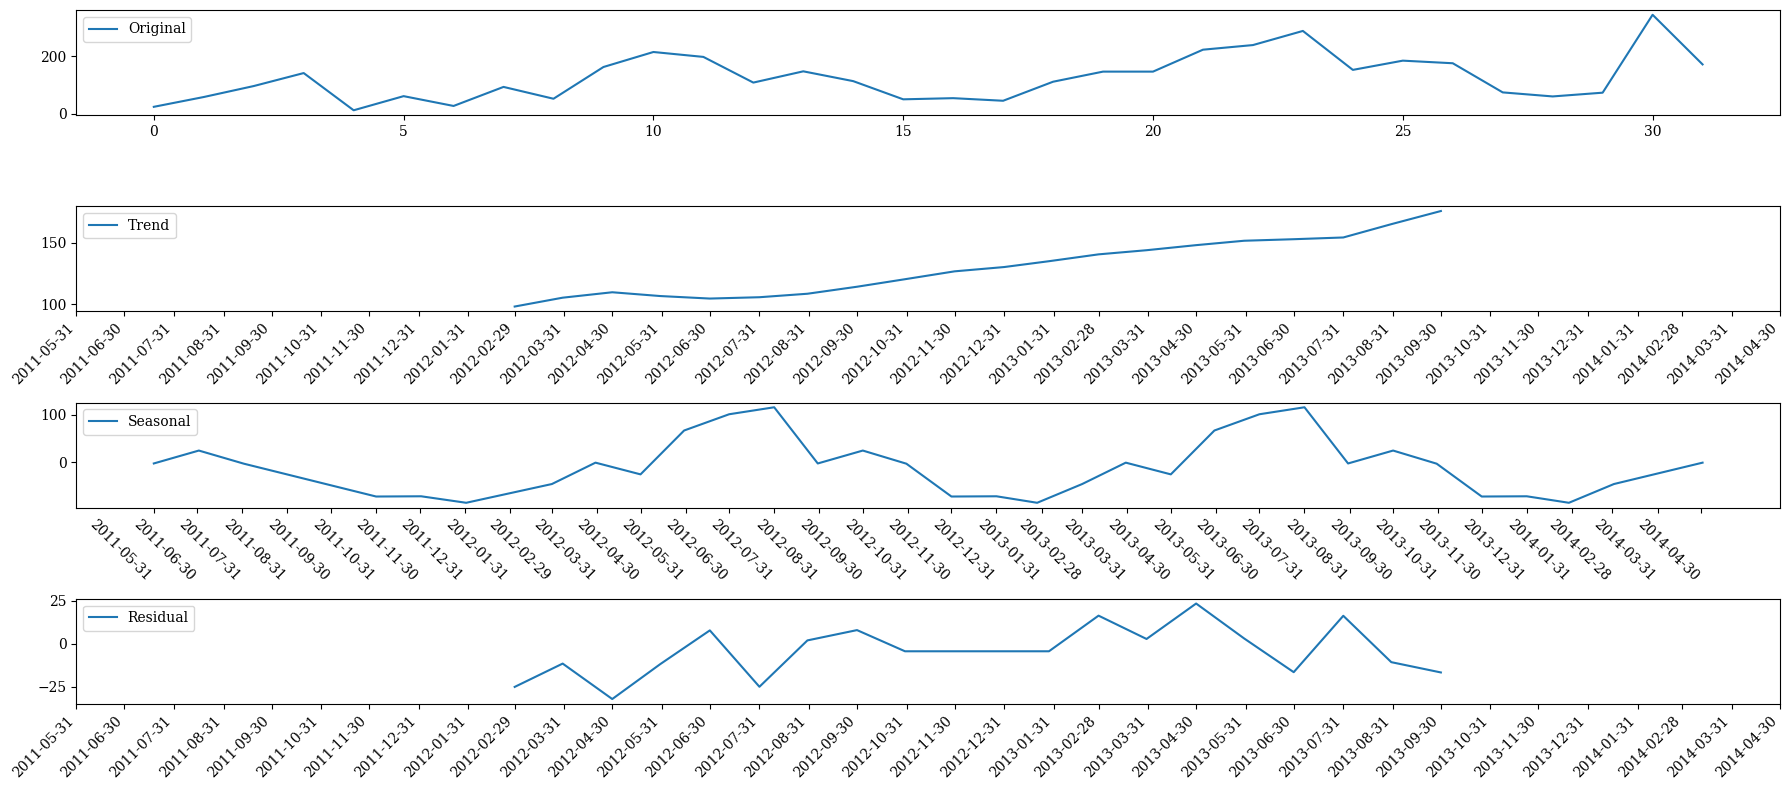

In [41]:
def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(18,8))

    plt.subplot(4,1,1)
    plt.plot(data['productquantity'], label="Original")
    plt.legend(loc='upper left')

    plt.subplot(4,1,2)
    plt.plot(seasonal_decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.xticks(pd.date_range(data['orderdate'].min(), data['orderdate'].max(), freq='M'))

    plt.subplot(4,1,3)
    plt.plot(seasonal_decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.xticks(rotation=-45, ha="right")
    plt.xticks(pd.date_range(data['orderdate'].min(), data['orderdate'].max(), freq='M'))

    plt.subplot(4,1,4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.xticks(pd.date_range(data['orderdate'].min(), data['orderdate'].max(), freq='M'))

    plt.tight_layout()
    plt.show()

result = seasonal_decompose(grouped_test.set_index('orderdate')['productquantity'], model='additive', period=12)
seasonal_decomposition_plots(data=grouped_test, seasonal_decomposition=result)

# Podemos observar que para o produto Sport-100 Helmet, Red. existe uma certa sazonalidade.

Previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja

In [205]:
df1.isnull().sum()
df1['storename'] = df['storename'].fillna("loja Online")

In [208]:
agrupado = df1.groupby(['productname', 'StoreID']).agg({'month': pd.Series.nunique}).reset_index()
pares_filtrados = agrupado[agrupado['month'] >= 5]

df2 = df1.merge(pares_filtrados[['productname', 'StoreID']], on=['productname', 'StoreID'], how='inner')
display(df2)

,productsalesId,productid,productcompletename,productname,productmakeflag,productfinishedgoodsflag,productsafetystocklevel,productreorderpoint,productstandardcost,productlistprice,...,territorycostytd,territorycostlastyear,salespersonid,salespersonbonusifquota,salespersonachievequota,productstotal,completetotal,categories,categoriesgroups,month
0,263,792,"Road-250 Red, 58 - BK-R89R-58","Road-250 Red, 58",True,True,100,75,1554.9479,2443.35,...,0,0,275,300000,Yes,946,1.232168e+08,Bikes,Bikes - Road Bikes,2012-05
1,319,792,"Road-250 Red, 58 - BK-R89R-58","Road-250 Red, 58",True,True,100,75,1554.9479,2443.35,...,0,0,275,300000,Yes,946,1.232168e+08,Bikes,Bikes - Road Bikes,2012-08
2,377,792,"Road-250 Red, 58 - BK-R89R-58","Road-250 Red, 58",True,True,100,75,1554.9479,2443.35,...,0,0,275,300000,Yes,946,1.232168e+08,Bikes,Bikes - Road Bikes,2012-11
3,31393,792,"Road-250 Red, 58 - BK-R89R-58","Road-250 Red, 58",True,True,100,75,1554.9479,2443.35,...,0,0,275,300000,Yes,946,1.232168e+08,Bikes,Bikes - Road Bikes,2013-05
4,31450,792,"Road-250 Red, 58 - BK-R89R-58","Road-250 Red, 58",True,True,100,75,1554.9479,2443.35,...,0,0,275,300000,Yes,946,1.232168e+08,Bikes,Bikes - Road Bikes,2013-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14701,60522,765,"Road-650 Black, 58 - BK-R50B-58","Road-650 Black, 58",True,True,100,75,486.7066,782.99,...,0,0,275,300000,Yes,1871,1.232168e+08,Bikes,Bikes - Road Bikes,2012-01
14702,60657,765,"Road-650 Black, 58 - BK-R50B-58","Road-650 Black, 58",True,True,100,75,486.7066,782.99,...,0,0,275,300000,Yes,1871,1.232168e+08,Bikes,Bikes - Road Bikes,2012-07
14703,60738,765,"Road-650 Black, 58 - BK-R50B-58","Road-650 Black, 58",True,True,100,75,486.7066,782.99,...,0,0,275,300000,Yes,1871,1.232168e+08,Bikes,Bikes - Road Bikes,2012-10
14704,60823,765,"Road-650 Black, 58 - BK-R50B-58","Road-650 Black, 58",True,True,100,75,486.7066,782.99,...,0,0,275,300000,Yes,1871,1.232168e+08,Bikes,Bikes - Road Bikes,2013-01


In [209]:
print('\nContagem de registros por unique id em clear_df:')
print(df2[['productname', 'storename']].value_counts().reset_index(name='count'))


Contagem de registros por unique id em clear_df:
                     productname                     storename  count
0                   AWC Logo Cap      Advanced Bike Components     12
1        Sport-100 Helmet, Black  Rewarding Activities Company     12
2     Long-Sleeve Logo Jersey, M                   Rapid Bikes     12
3     Long-Sleeve Logo Jersey, M  Rewarding Activities Company     12
4     Long-Sleeve Logo Jersey, M     Vigorous Exercise Company     12
...                          ...                           ...    ...
2126     LL Road Frame - Red, 44               Every Bike Shop      5
2127          Road-650 Black, 44               Every Bike Shop      5
2128          Road-650 Black, 44         Finer Riding Supplies      5
2129          Road-650 Black, 44              First Bike Store      5
2130   LL Road Frame - Black, 58                Riders Company      5

[2131 rows x 3 columns]


In [183]:
hierarchies = [
    ['productname'],
    ['territoryname'],
    ['territoryname', 'storename'],
    ['territoryname', 'storename', 'productname'],
]

In [184]:
hts = (
    df2
    .groupby(["month", "productname", "storename", "territoryname"])["productquantity"].sum()
    .reset_index()
    .rename(columns={"month": "ds", "productquantity": "y"})
)


In [188]:
Y_df, S_df, tags = aggregate(hts, hierarchies)
Y_df = Y_df.reset_index()
Y_df['ds'] = Y_df['ds'].dt.to_timestamp()
display(Y_df)

,unique_id,ds,y
0,AWC Logo Cap,2011-05-01,31
1,AWC Logo Cap,2011-07-01,38
2,AWC Logo Cap,2011-08-01,69
3,AWC Logo Cap,2011-10-01,108
4,AWC Logo Cap,2011-12-01,17
...,...,...,...
29010,United Kingdom/Year-Round Sports/HL Road Frame...,2012-05-01,2
29011,United Kingdom/Year-Round Sports/HL Road Frame...,2013-02-01,1
29012,United Kingdom/eCommerce Bikes/HL Road Frame -...,2013-05-01,2
29013,United Kingdom/eCommerce Bikes/HL Road Frame -...,2013-02-01,1


In [189]:
from datetime import datetime, timedelta
import pandas as pd

# Supondo que Y_df é seu DataFrame original
unique_ids = Y_df['unique_id'].unique()
start_date = Y_df['ds'].min()
end_date = Y_df['ds'].max()  # Corrigido: Faltava o sinal de igual (=) após end_date

# Criando um dataframe com todas as combinações possíveis de unique_id e ds:
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # Corrigido: Faltava o sinal de igual (=) após date_range
all_combinations = pd.DataFrame([(unique_id, date) for unique_id in unique_ids for date in date_range], columns=['unique_id', 'ds'])  # Corrigido: Faltava o sinal de igual (=) após all_combinations

# Juntando esse dataframe com o dataframe original
complete_df = pd.merge(all_combinations, Y_df, on=['unique_id', 'ds'], how='left')  # Corrigido: Faltava o sinal de igual (=) após complete_df

# Preenchendo com 0 os meses sem venda
complete_df['y'] = complete_df['y'].fillna(0)  # Corrigido: Substituí "e" por 0 para preencher os meses sem venda

# Exibindo o DataFrame completo
display(complete_df)


,unique_id,ds,y
0,AWC Logo Cap,2011-05-01,31
1,AWC Logo Cap,2011-06-01,0
2,AWC Logo Cap,2011-07-01,38
3,AWC Logo Cap,2011-08-01,69
4,AWC Logo Cap,2011-09-01,0
...,...,...,...
417133,"United Kingdom/eCommerce Bikes/Road-250 Red, 58",2014-01-01,0
417134,"United Kingdom/eCommerce Bikes/Road-250 Red, 58",2014-02-01,0
417135,"United Kingdom/eCommerce Bikes/Road-250 Red, 58",2014-03-01,0
417136,"United Kingdom/eCommerce Bikes/Road-250 Red, 58",2014-04-01,0


In [191]:
# Selecionando as últimas 3 observações de cada 'unique_id' para o conjunto de teste
Y_test_df = complete_df.groupby('unique_id').tail(3)

# Criando o conjunto de treinamento excluindo as observações selecionadas para o conjunto de teste
Y_train_df = complete_df.drop(Y_test_df.index)

# Exibindo as dimensões dos conjuntos de treinamento e teste para verificação
display(Y_train_df.shape)
display(Y_test_df.shape)


(383316, 3)

(33822, 3)

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

# Calculando as previsões utilizando o modelo AutoARIMA e Naive
# (ETS não funciona com tão poucos registros)
fcst = StatsForecast(df=Y_train_df,
                     models=[AutoARIMA(season_length=12), Naive()],
                     freq='M',
                     n_jobs=-1)

# Forecast do Y_train_df (análogo ao fit_predict)
Y_hat_train2 = fcst.forecast(h=3)


estimativas para pares de luvas